In [1]:
import os
import sys
import time
import argparse
import numpy as np
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import DataLoader
from models.efficientdet import EfficientDet
from models.losses import FocalLoss
from datasets import Maritime_Dataset, get_augumentation, detection_collate
from utils import EFFICIENTDET
import cv2
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

In [2]:
resume = None
network = 'efficientdet-d3'
num_epochs = 50
batch_size = 1
num_worker = 4
num_classes = 10
device = [0]
grad_accumulation_steps = 1
learning_rate = 1e-4
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
save_folder = '../Maritime_Data/weights/'
image_root = '../Maritime_Data/on_shore_frames/'
csv_root = '../Maritime_Data/'

In [3]:
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

In [4]:
def prepare_device(device):
    n_gpu_use = len(device)
    n_gpu = torch.cuda.device_count()
    if n_gpu_use > 0 and n_gpu == 0:
        print("Warning: There\'s no GPU available on this machine, training will be performed on CPU.")
        n_gpu_use = 0
    if n_gpu_use > n_gpu:
        print("Warning: The number of GPU\'s configured to use is {}, but only {} are available on this machine.".format(
            n_gpu_use, n_gpu))
        n_gpu_use = n_gpu
    list_ids = device
    device = torch.device('cuda:{}'.format(
        device[0]) if n_gpu_use > 0 else 'cpu')

    return device, list_ids

In [5]:
def get_state_dict(model):
    if type(model) == torch.nn.DataParallel:
        state_dict = model.module.state_dict()
    else:
        state_dict = model.state_dict()
    return state_dict

In [6]:
checkpoint = []
if(resume is not None):
    resume_path = str(resume)
    print("Loading checkpoint: {} ...".format(resume_path))
    checkpoint = torch.load(
        resume, map_location=lambda storage, loc: storage)
    num_classes = checkpoint['num_classes']
    network = checkpoint['network']

In [7]:
filename_df = pd.read_csv(csv_root+'onshore_filenames_train.csv')
filename_df_train = pd.read_csv(csv_root+'onshore_filenames_train.csv')
boxes_df = pd.read_csv(csv_root+'onshore_boxes.csv')
filename_df_test = pd.read_csv(csv_root+'onshore_filenames_val.csv')
# boxes_df['label'] = 0

In [8]:
boxes_df.head()

,fname,xmin,ymin,xmax,ymax,label
0,MVI_1469_VIS_0_.png,1134,433,1525,620,3
1,MVI_1469_VIS_0_.png,389,442,726,562,3
2,MVI_1469_VIS_0_.png,366,534,407,581,4
3,MVI_1469_VIS_0_.png,224,580,324,731,2
4,MVI_1469_VIS_0_.png,80,437,275,526,3


In [9]:
(1080,1920)

(1080, 1920)

In [10]:
boxes_df.ymax.clip(0,1080,axis=0,inplace=True)
boxes_df.ymin.clip(0,1080,axis=0,inplace=True)
boxes_df.xmin.clip(0,1920,axis=0,inplace=True)
boxes_df.xmax.clip(0,1920,axis=0,inplace=True)

In [11]:
boxes_df.label.value_counts()

3     118473
10     12695
1       8588
4       8523
6       4308
2       3642
7       1926
5       1379
9        650
0          1
Name: label, dtype: int64

In [12]:
os.path.join(image_root, filename_df_train.iloc[0,0])

'../Maritime_Data/on_shore_frames/MVI_1448_VIS_Haze_0_.png'

In [13]:
train_dataset = Maritime_Dataset.Maritime_Dataset(image_root,boxes_df,filename_df_train,transform=get_augumentation('train'))

In [14]:
test_dataset = Maritime_Dataset.Maritime_Dataset(image_root,boxes_df,filename_df_test,transform=get_augumentation('test'))

In [15]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=True,
                              collate_fn=detection_collate,
                              pin_memory=True)

In [16]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True)


In [17]:
for idx, (images, annotations) in enumerate(train_dataloader):
    print(idx ,images.shape, annotations.shape)
    break

0 torch.Size([1, 3, 512, 512]) torch.Size([1, 7, 5])


In [18]:
def plotter(frame_id):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    img = cv2.imread(f'{image_root}/{frame_id}')
    plt.imshow(img)
    bboxes = boxes_df[boxes_df.fname == frame_id]
    bbox = bboxes.iloc[:,1:5].values
    for box in bbox:
        xmin,ymin,xmax,ymax = box
        w = xmax-xmin
        h = ymax-ymin
        rect = patches.Rectangle((xmin,ymin), w, h, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)    
    plt.show()

In [19]:
(boxes_df.iloc[:,1:5].values<0).sum()

0

In [20]:
(boxes_df.iloc[:,1:5].values>0).sum()

635249

MVI_1481_VIS_156_.png


NameError: name 'patches' is not defined

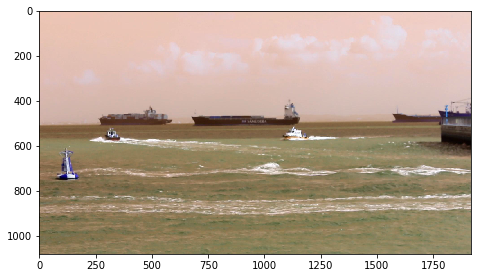

In [21]:
choices = np.random.choice(filename_df_train.iloc[:,0].values,10)
for i in choices:
    print(i)
    plotter(i)

In [22]:
model = EfficientDet(num_classes=num_classes,
                     network=network,
                     W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                     D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                     D_class=EFFICIENTDET[network]['D_class'],
                     )

Loaded pretrained weights for efficientnet-b3


In [23]:
if(resume is not None):
    model.load_state_dict(checkpoint['state_dict'])
device, device_ids = prepare_device(device)
model = model.to(device)
if(len(device_ids) > 1):
    model = torch.nn.DataParallel(model, device_ids=device_ids)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, verbose=True)
criterion = FocalLoss()

In [ ]:
model.train()
df = pd.DataFrame(np.zeros((num_epochs,4)),columns = ["train_cls","train_bbox_loss","val_cls","val_bbox_loss"])
for epoch in range(num_epochs):
    print("{} epoch: \t start training....".format(epoch))
    
    start = time.time()
    result = {}
    total_loss = []
    bbox_losses = []
    cls_losses = []
    optimizer.zero_grad()
    total_batches = len(train_dataloader)
    tk0 = tqdm(train_dataloader, total=total_batches)
    for idx, (images, annotations_bboxes) in enumerate(tk0):
        images = images.to(device)
        annotations = annotations.to(device)
        classification, regression, anchors = model(images)
        classification_loss, regression_loss = criterion(
            classification, regression, anchors, annotations)
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        loss = classification_loss + regression_loss
        if bool(loss == 0):
            print('loss equal zero(0)')
            continue
        loss.backward()
        if (idx+1) % grad_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            optimizer.zero_grad()
        total_loss.append(loss.item())
        bbox_losses.append(regression_loss.item())
        cls_losses.append(classification_loss.item())
        tk0.set_postfix(loss=(np.mean(total_loss)))
    result = {
        'time': time.time() - start,
        'loss': np.mean(total_loss),
        'bbox_loss': np.mean(bbox_losses),
        'cls_loss': np.mean(cls_losses)
    }
    for key, value in result.items():
        print('    {:15s}: {}'.format(str(key), value))
    df.iloc[epoch,:2] = [np.mean(cls_losses),np.mean(bbox_losses)] 
    torch.cuda.empty_cache()
    with torch.no_grad():
        start = time.time()
        result = {}
        total_loss = []
        bbox_losses = []
        cls_losses = []
        optimizer.zero_grad()
        total_batches = len(test_dataloader)
        tk0 = tqdm(test_dataloader, total=total_batches)
        for idx, (images, annotations_bboxes) in enumerate(tk0):
            images = images.to(device)
            annotations_bboxes = annotations_bboxes.to(device)
            classification, regression, anchors = model(images)
            classification_loss, regression_loss = criterion(
                classification, regression, anchors, annotations)
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = 0.1*classification_loss + regression_loss
            if bool(loss == 0):
                print('loss equal zero(0)')
                continue
            total_loss.append(loss.item())
            bbox_losses.append(regression_loss.item())
            cls_losses.append(classification_loss.item())
            tk0.set_postfix(loss=(np.mean(total_loss)))
        result = {
            'time': time.time() - start,
            'loss': np.mean(total_loss),
            'bbox_loss': np.mean(bbox_losses),
            'cls_loss': np.mean(cls_losses)
        }
        for key, value in result.items():
            print('    {:15s}: {}'.format(str(key), value))
        scheduler.step(np.mean(total_loss))
    df.iloc[epoch,2:] = [np.mean(cls_losses),np.mean(bbox_losses)]
    df.to_csv('d3-weight-0.1.csv')
    torch.cuda.empty_cache()
    arch = type(model).__name__
    state = {
        'arch': arch,
        'num_class': num_classes,
        'network': network,
        'state_dict': get_state_dict(model)
    }
    torch.save(
        state, './weights/checkpoint_{}_{}.pth'.format(network, epoch))
state = {
    'arch': arch,
    'num_class': num_classes,
    'network': network,
    'state_dict': get_state_dict(model)
}
torch.save(state, './weights/Final_{}.pth'.format(network))


0 epoch: 	 start training....


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




    time           : 1237.5007100105286
    loss           : 2.6554300380763767
    bbox_loss      : 0.11457958446834668
    cls_loss       : 2.5408504911672765



    time           : 943.1778151988983
    loss           : 0.01414418214727744
    bbox_loss      : 0.014144168186902676
    cls_loss       : 1.3943689569212226e-07
1 epoch: 	 start training....


In [ ]:
model.train()
    iteration = 1
    for epoch in range(args.num_epoch):
        print("{} epoch: \t start training....".format(epoch))
        start = time.time()
        result = {}
        total_loss = []
        optimizer.zero_grad()
        for idx, (images, annotations) in enumerate(train_dataloader):
            images = images.to(device)
            annotations = annotations.to(device)
            classification, regression, anchors = model(images)
            classification_loss, regression_loss = criterion(
                classification, regression, anchors, annotations)
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss
            if bool(loss == 0):
                print('loss equal zero(0)')
                continue
            loss.backward()
            if (idx+1) % args.grad_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                optimizer.step()
                optimizer.zero_grad()

            total_loss.append(loss.item())
            if(iteration % 100 == 0):
                print('{} iteration: training ...'.format(iteration))
                ans = {
                    'epoch': epoch,
                    'iteration': iteration,
                    'cls_loss': classification_loss.item(),
                    'reg_loss': regression_loss.item(),
                    'mean_loss': np.mean(total_loss)
                }
                for key, value in ans.items():
                    print('    {:15s}: {}'.format(str(key), value))

            iteration += 1
        scheduler.step(np.mean(total_loss))
        result = {
            'time': time.time() - start,
            'loss': np.mean(total_loss)
        }
        for key, value in result.items():
            print('    {:15s}: {}'.format(str(key), value))
        arch = type(model).__name__
        state = {
            'arch': arch,
            'num_class': args.num_classes,
            'network': args.network,
            'state_dict': get_state_dict(model)
        }
        torch.save(
            state, './weights/checkpoint_{}_{}_{}.pth'.format(args.dataset, args.network, epoch))
    state = {
        'arch': arch,
        'num_class': args.num_class,
        'network': args.network,
        'state_dict': get_state_dict(model)
    }
    torch.save(state, './weights/Final_{}.pth'.format(args.network))
